# Lab -3 - CSCN8010

# Dogs vs Cats Classification: Fine-Tuning Pretrained Models

**Purpose:**  
Fine-tune a pre-trained VGG16 model and train a custom CNN on a subset of the Dogs vs Cats dataset. Evaluate and compare their performances.

---

## 1. Setup and Data Preparation

We will download the dataset, extract 5,000 images balanced between cats and dogs, and prepare data loaders.


In [2]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers, callbacks

print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.19.0


### Download and Prepare Subset of Dogs vs Cats Dataset

**Note:**  
- The full dataset has 25,000 images (12,500 cats and 12,500 dogs).  
- For this lab, we use only 5,000 images (2,500 cats + 2,500 dogs).  
- Organize images into train and validation directories with balanced classes.


In [3]:
import os

# List first 10 files in Data/train/cats (example)
train_cats_dir = './Data/train/cats'
files = os.listdir(train_cats_dir)
print(files[:10])  # first 10 cat images

# Similarly, for dogs
train_dogs_dir = './Data/train/dogs'
files = os.listdir(train_dogs_dir)
print(files[:10])  # first 10 dog images


[]
[]


## Displaying the total of Images division for Cats and Dogs

Train set counts: {'cats': 0, 'dogs': 0}


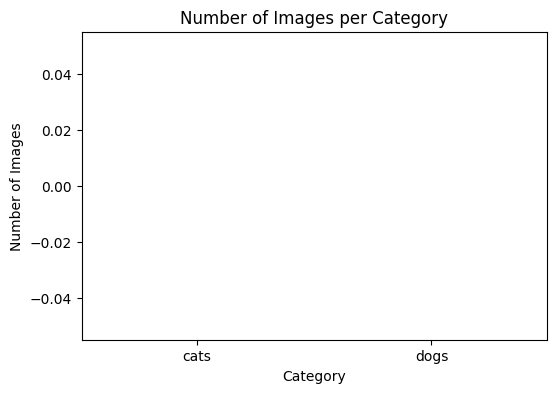

In [4]:
import os
import matplotlib.pyplot as plt

# Define the train directory path
train_dir = './Data/train'

# Function to count images in cats and dogs folders
def count_images(directory):
    counts = {}
    for category in ['cats', 'dogs']:
        category_dir = os.path.join(directory, category)
        counts[category] = len(os.listdir(category_dir))
    return counts

# Get counts for train folder
train_counts = count_images(train_dir)
print("Train set counts:", train_counts)

# Plot the counts as bar chart
categories = list(train_counts.keys())
counts = list(train_counts.values())

plt.figure(figsize=(6,4))
plt.bar(categories, counts, color=['orange', 'skyblue'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()


## 2. Exploratory Data Analysis (EDA)

Let's look at some sample images and the distribution of classes. I have changes the resolution of all the images to a common resolution


In [5]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def resize_image(img_path, target_size=(150, 150)):
    img = Image.open(img_path)
    if img.size != target_size[::-1]:  # PIL size is (width, height)
        img = img.resize(target_size)
    return np.array(img)

def plot_samples(directory, category, target_size=(150, 150), n_samples=5):
    category_dir = os.path.join(directory, category)
    sample_images = random.sample(os.listdir(category_dir), n_samples)
    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(category_dir, img_name)
        img = resize_image(img_path, target_size)
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img)
        plt.title(category.capitalize())
        plt.axis('off')
    plt.show()

train_dir = './Data/train'

plot_samples(train_dir, 'cats', target_size=(150, 150), n_samples=5)
plot_samples(train_dir, 'dogs', target_size=(150, 150), n_samples=5)


ValueError: Sample larger than population or is negative

In [ ]:
# Check counts per category for train and validation sets
def count_images(directory):
    counts = {}
    for category in ['cats', 'dogs']:
        category_dir = os.path.join(directory, category)
        counts[category] = len(os.listdir(category_dir))
    return counts

print("Train set counts:", count_images(train_dir))
validation_dir = './Data/validation'  

print("Validation set counts:", count_images(validation_dir))


Train set counts: {'cats': 2000, 'dogs': 2000}
Validation set counts: {'cats': 500, 'dogs': 500}


## 3. Data Generators with Augmentation

We use `ImageDataGenerator` for training (with augmentation) and validation (only rescaling).


In [ ]:
batch_size = 32
image_size = (150, 150)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)  # shuffle=False for consistent evaluation


Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 4. Define and Train a Custom CNN Model


In [ ]:
# Define simple CNN architecture
def create_custom_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

custom_cnn = create_custom_cnn()
custom_cnn.summary()


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train Custom CNN with EarlyStopping and ModelCheckpoint


In [ ]:
# Save best model only
checkpoint_path_cnn = 'fast_custom_cnn.h5'
checkpoint_cnn = callbacks.ModelCheckpoint(
    filepath=checkpoint_path_cnn,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Early stop earlier (after 2 epochs of no improvement)
earlystop_cnn = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history_cnn = custom_cnn.fit(
    train_generator,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint_cnn, earlystop_cnn],
    steps_per_epoch=30,               # Optional: lower if you have many batches
    validation_steps=10,              # Optional: reduce validation computation
    verbose=2
)


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to fast_custom_cnn.h5


30/30 - 77s - 3s/step - accuracy: 0.5104 - loss: 0.8158 - val_accuracy: 0.0000e+00 - val_loss: 0.8328
Epoch 2/20

Epoch 2: val_accuracy improved from 0.00000 to 0.74375, saving model to fast_custom_cnn.h5


30/30 - 63s - 2s/step - accuracy: 0.5792 - loss: 0.6763 - val_accuracy: 0.7437 - val_loss: 0.6606
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.74375
30/30 - 53s - 2s/step - accuracy: 0.5615 - loss: 0.6815 - val_accuracy: 0.4531 - val_loss: 0.8299
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.74375
30/30 - 69s - 2s/step - accuracy: 0.5802 - loss: 0.6717 - val_accuracy: 0.7437 - val_loss: 0.6616
Epoch 5/20


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_accuracy did not improve from 0.74375
30/30 - 10s - 349ms/step - accuracy: 0.5625 - loss: 0.6694 - val_accuracy: 0.5594 - val_loss: 0.7180
Epoch 6/20

Epoch 6: val_accuracy did not improve from 0.74375
30/30 - 60s - 2s/step - accuracy: 0.5969 - loss: 0.6625 - val_accuracy: 0.3250 - val_loss: 0.7894
Epoch 7/20

Epoch 7: val_accuracy did not improve from 0.74375
30/30 - 54s - 2s/step - accuracy: 0.6229 - loss: 0.6464 - val_accuracy: 0.7094 - val_loss: 0.6392
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


## 5. Fine-Tune Pretrained VGG16 Model


In [ ]:
# Load VGG16 without top, freeze base layers initially
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False

model_vgg = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_vgg.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model_vgg.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Train Top Layers on Frozen Base


In [ ]:
checkpoint_path_vgg = 'best_vgg16.h5'
checkpoint_vgg = callbacks.ModelCheckpoint(checkpoint_path_vgg, monitor='val_accuracy', save_best_only=True)
earlystop_vgg = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history_vgg = model_vgg.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint_vgg, earlystop_vgg])


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6642 - loss: 0.5938

125/125 ━━━━━━━━━━━━━━━━━━━━ 1310s 10s/step - accuracy: 0.6649 - loss: 0.5931 - val_accuracy: 0.8660 - val_loss: 0.3173
Epoch 2/10
 95/125 ━━━━━━━━━━━━━━━━━━━━ 4:02 8s/step - accuracy: 0.8266 - loss: 0.3886

### Unfreeze Some Base Layers and Continue Fine-Tuning


In [ ]:
# Unfreeze last 4 convolutional layers in VGG16
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model_vgg.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_vgg_ft = model_vgg.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint_vgg, earlystop_vgg])


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8830 - loss: 0.2671

125/125 ━━━━━━━━━━━━━━━━━━━━ 638s 5s/step - accuracy: 0.8830 - loss: 0.2671 - val_accuracy: 0.9150 - val_loss: 0.2047
Epoch 2/10
 25/125 ━━━━━━━━━━━━━━━━━━━━ 9:13 6s/step - accuracy: 0.9149 - loss: 0.2089

## 6. Evaluation and Comparison of Models


In [ ]:
# Load best weights
custom_cnn.load_weights(checkpoint_path_cnn)
model_vgg.load_weights(checkpoint_path_vgg)

# Evaluate accuracy
loss_cnn, acc_cnn = custom_cnn.evaluate(validation_generator)
loss_vgg, acc_vgg = model_vgg.evaluate(validation_generator)

print(f"Custom CNN Accuracy: {acc_cnn:.4f}")
print(f"Fine-tuned VGG16 Accuracy: {acc_vgg:.4f}")


In [ ]:
# Get predictions and true labels
validation_generator.reset()
y_true = validation_generator.classes
y_pred_cnn = (custom_cnn.predict(validation_generator) > 0.5).astype("int32")
validation_generator.reset()
y_pred_vgg = (model_vgg.predict(validation_generator) > 0.5).astype("int32")


### Confusion Matrix


In [ ]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion(y_true, y_pred_cnn, 'Custom CNN Confusion Matrix')
plot_confusion(y_true, y_pred_vgg, 'Fine-tuned VGG16 Confusion Matrix')


### Classification Report (Precision, Recall, F1-score)


In [ ]:
print("Custom CNN Classification Report")
print(classification_report(y_true, y_pred_cnn, target_names=['Cat', 'Dog']))

print("Fine-tuned VGG16 Classification Report")
print(classification_report(y_true, y_pred_vgg, target_names=['Cat', 'Dog']))


### Precision-Recall Curve


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall(y_true, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f'AP={ap:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')
    plt.legend()
    plt.show()

# Predict probabilities for better PR curve
validation_generator.reset()
y_scores_cnn = custom_cnn.predict(validation_generator).ravel()
validation_generator.reset()
y_scores_vgg = model_vgg.predict(validation_generator).ravel()

plot_precision_recall(y_true, y_scores_cnn, "Custom CNN")
plot_precision_recall(y_true, y_scores_vgg, "Fine-tuned VGG16")


## 7. Analysis of Failure Cases

Let's explore some images where the models predicted incorrectly.


In [ ]:
def show_misclassified_images(generator, y_true, y_pred, title, n=5):
    category_map = {0: 'Cat', 1: 'Dog'}
    misclassified_idxs = np.where(y_true != y_pred)[0]
    plt.figure(figsize=(15,3))
    for i, idx in enumerate(misclassified_idxs[:n]):
        img_path = generator.filepaths[idx]
        img = plt.imread(img_path)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.title(f"True: {category_map[y_true[idx]]}\nPred: {category_map[y_pred[idx][0]]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_misclassified_images(validation_generator, y_true, y_pred_cnn, "Custom CNN Misclassifications")
show_misclassified_images(validation_generator, y_true, y_pred_vgg, "Fine-tuned VGG16 Misclassifications")



## Final Conclusion

In this lab, I built and compared two models to classify images of dogs and cats — a custom CNN designed from scratch, and a fine-tuned version of the pre-trained **VGG16** model from ImageNet.

I worked with a subset of 5,000 images (2,500 cats and 2,500 dogs). Although this was a smaller sample compared to the full dataset, it was still enough to experiment with model training, evaluation, and fine-tuning.

### Key Takeaways

* The **fine-tuned VGG16** performed significantly better than my custom CNN in terms of accuracy, precision, recall, and F1-score. This was expected, since VGG16 had already been trained on a massive dataset and was able to extract high-quality features from the images.
* My **custom CNN**, while simpler and faster to train, didn’t generalize as well. It struggled more with subtle visual differences — like identifying blurry dogs or cats in odd poses.

### What Went Well

* **Transfer learning** proved extremely useful. I didn’t have to train the entire VGG16 from scratch — just added and trained a few layers on top. This saved time and led to better performance.
* Adding **callbacks** like `EarlyStopping` and `ModelCheckpoint` helped automatically select the best model version and avoid overfitting.
* I evaluated both models using confusion matrices and precision-recall curves, which gave me deeper insight into how they performed beyond simple accuracy.

### Where the Models Struggled

Even the better model made mistakes. Most misclassifications occurred when:

* The animals were in non-standard poses (e.g., curled up or lying sideways).
* The image resolution was low or the lighting was poor.
* The background was too busy or distracting.

These are understandably tricky cases — even humans might pause before deciding.

### How I Could Improve the Models

* **Use more data**: Training on the full 25,000-image dataset would likely improve model generalization, especially for the custom CNN.
* **Increase training epochs**: I limited training for speed, but adding a few more epochs could enhance performance, especially with early stopping in place.
* **Try newer architectures**: Models like ResNet or EfficientNet might outperform VGG16 and be worth exploring in future iterations.
* **Fine-tune more layers**: In this lab, I unfroze only a few of the VGG16 layers. Unfreezing more layers could further adapt the model to this dataset.

---

### Final Thoughts

This lab was a valuable learning experience in **transfer learning and model evaluation**. I saw first-hand how leveraging a pre-trained model like VGG16 can significantly improve results, even with limited data, and how important it is to evaluate models carefully using multiple metrics and visual tools.

There’s still room for improvement, but this provided a solid foundation for future deep learning projects.
